## Imports

In [49]:
#Systems imports
import os
import sys
from datetime import datetime
from pathlib import Path
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt

#ML imports
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as statsmodels

## Step 1 - Data Preprocessing

Rassembler les comptages d'ARN pour chaque échantillon dans un DataFrame. <br>
Chaque ligne du DataFrame doit représenter un échantillon et chaque colonne doit représenter un gène.

### RNA counts :

#### Sample class : 

In [50]:
class Sample:
    
    # --- Constructeur ---
    def __init__(self, fichierTxt):
        self.df = (pd.read_csv(fichierTxt, sep="\t", index_col = 0)) # Lecture du fichier texte et stockage dans un objet DataFrame
        self.DataFrame = self.df.T # Transposition de l'objet DataFrame

    # --- Méthode ---
    def printSample(self):
        display((self.DataFrame))

    # --- Getter ---
    def get_DataFrame(self):
        return self.DataFrame

#### RNA Samples class : 

In [51]:
class Data_Matrix:
    
    # --- Constructeur ---
    def __init__(self, directory):
        arraySamples = [] # Initialisation d'un tableau vide pour stocker les objets DataFrame de chaque fichier texte
        for filename in os.listdir(directory): # Itération à travers tous les fichiers du répertoire spécifié
            f = os.path.join(directory, filename) # Chemin complet du fichier
            if os.path.isfile(f) and filename.endswith('.txt'): # Vérification que le fichier est bien un fichier texte
                sample = Sample(f) # Création d'un objet Sample à partir du fichier texte
                index_name_to_rename = sample.get_DataFrame().index[0] # Récupération du nom d'index pour renommer l'objet DataFrame
                sample_df_renamed = sample.get_DataFrame().rename(index={index_name_to_rename: filename[filename.find("GSM"):filename.find("_")]}) # Renommage de l'objet DataFrame
                arraySamples.append(sample_df_renamed) # Ajout de l'objet DataFrame renommé dans le tableau

        self.df = pd.concat(arraySamples) # Concaténation de tous les objets DataFrame en un seul objet DataFrame pour créer une base de données globale
        self.pca = None
        self.p_values = []
     
    # --- Getters ---
    def get_DataFrame(self):
        return self.df
    
    def get_PCA(self):
        return self._pca
    
    def get_P_Values(self):
        return self._p_values
    
    # --- Setters ---
    def set_DataFrame(self, DataFrame):
        self.df = DataFrame;
        
    # --- Méthodes ---
    def afficher(self):
         # Affichage de l'objet DataFrame global
        display(self.df)
    
    def clean_DataFrame(self):
        cpt = 0
        temp_Df = self.df
        for i in self.df:
            arr = temp_Df[i].to_numpy()
            if((arr[0] == arr).all()):
                temp_Df = temp_Df.drop(i, axis=1)
                cpt += 1
            if(True in np.isnan(arr)):
                temp_Df = temp_Df.drop(i, axis=1)
                cpt += 1
        print("Nous avons supprimes :", cpt, "colonnes du DataFrame")
        return temp_Df
        
    def apply_One_Hot(self):
        Dataset_encoded = pd.get_dummies(self.get_DataFrame())
        self.set_DataFrame(Dataset_encoded)
    
    def apply_PCA(self, N_COMP):
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(self.get_DataFrame())
        #N_COMP = 4   #Mettre 20 dans le rapport pour justifier le choix de 4
        self.pca = decomposition.PCA(n_components=N_COMP)
        xps_train = self.pca.fit_transform(X)

    def plot_PCA(self):
        if(self.pca == None):
            print("PCA has not been applied, use _apply_PCA(N_Comp) first")
        else:
            pc2 = np.arange(self.pca.n_components_) + 1
            plt.plot(pc2, self.pca.explained_variance_ratio_, 'o-')
            plt.title("Scree Plot")
            plt.xlabel("Principal Component")
            plt.ylabel("Variance Explained")
            plt.show()
            
    def calculate_P_Values(self, annoted_Df):
        als_index = annoted_Df.get_DataFrame()['Sample group'] == "ALS Spectrum MND" # with data_annotation the dataframe containing the annotation
        ctrl_index = annoted_Df.get_DataFrame()['Sample group'] == "Non-Neurological Control"
        temp_P_val = self._get_DataFrame().apply(lambda x: ttest_ind(x[als_index.values], x[ctrl_index.values], nan_policy = 'omit').pvalue)
        
        for i in temp_P_val:
            if(not np.isnan(i)):
                self._p_values.append(i)
        #self._p_values = np.where(np.isnan(self._p_values.values), 0.5, self._p_values.values)

In [52]:
DataMatrix = Data_Matrix("Data/")
DataMatrix.afficher()

gene/TE,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533405,76,193,0,4278,140,102,2,3,141,0,...,695,1782,1432,929,67,456,104,427,1619,1751
GSM3533404,124,332,0,3516,141,173,3,2,192,0,...,743,1846,1680,936,110,479,120,503,1646,1839
GSM3533403,64,290,0,4752,118,174,8,2,135,0,...,623,1466,1246,726,61,358,107,347,1284,1469
GSM3533402,134,300,0,6077,171,42,8,5,225,0,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533401,23,113,0,2130,72,71,2,3,21,0,...,553,1243,1089,658,72,320,73,311,1102,1169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533234,22,102,0,1706,83,178,1,3,31,0,...,966,2295,1993,1152,96,582,124,539,1742,1939
GSM3533233,22,101,0,2131,142,143,5,1,36,0,...,935,2278,2032,1198,97,562,132,540,2032,2135
GSM3533232,20,95,0,1830,121,127,1,1,11,0,...,905,2018,1815,1011,84,571,126,479,1659,1778
GSM3533231,25,107,2,1787,153,109,2,1,25,0,...,1216,2373,2001,1144,118,582,153,552,2057,2279


#### Filtrage des données :

On exclut les gènes avec faible comptage moyen

In [53]:
df_means = DataMatrix.get_DataFrame().mean(axis=0)

In [54]:
# On a fixé le seuil de pertinance des moyennes à 5
df_filtered = DataMatrix.get_DataFrame().loc[:, df_means > 4] 
DataMatrix.set_DataFrame(df_filtered)

In [55]:
print (DataMatrix.get_DataFrame().shape)

(176, 20526)


#### sample annotations class : 

In [56]:
class sample_Annotation:
    
    # --- Constructeur ---
    def __init__(self, XML_File):
        self.DataFrame = pd.DataFrame() 
        temp = []
        xtree = et.parse('./Data/GSE124439_family.xml') 

        xroot = xtree.getroot() 
        for child in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
            temp_sample_id = child.attrib['iid'] 
            temp_cns_subregion = ""
            temp_cns_tissu = ""
            temp_cns_subject = ""
            temp_cns_sample = ""
            temp_cns_source = ""
            for child2 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
                if(child2.attrib["tag"] == "cns subregion"):
                    temp_cns_subregion = str.strip(child2.text.replace('\n', ''))
                #if(child2.attrib["tag"] == "tissue type"):
                    #temp_cns_tissu = str.strip(child2.text.replace('\n', ''))
                if(child2.attrib["tag"] == "subject id"):
                    temp_cns_subject = str.strip(child2.text.replace('\n', ''))
                if(child2.attrib["tag"] == "sample group"):
                    temp_cns_sample = str.strip(child2.text.replace('\n', ''))
            #for child3 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Source"):    
                #temp_cns_source = str.strip(child3.text)
            
            temp_df = pd.DataFrame({'gene/TE': [temp_sample_id], 'Cns_subregion': [temp_cns_subregion], "Subject id": [temp_cns_subject],  "Sample group": [temp_cns_sample]})
            temp_df = temp_df.set_index('gene/TE')
            self.DataFrame = pd.concat([self.DataFrame, temp_df])
            self.DataFrame.reindex(index=self.DataFrame.index[::-1])
            
    # --- Getters ---
    def get_DataFrame(self):
        return self.DataFrame
    
    # --- Méthodes ---
    def afficher(self):
        with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
            display(self.DataFrame)

In [57]:
mesAnnotations = sample_Annotation("Data/GSE124439_family.xml")
mesAnnotations.afficher()

,Cns_subregion,Subject id,Sample group
gene/TE,,,
GSM3533230,Frontal Cortex,NEUEL133AK6,ALS Spectrum MND
GSM3533231,Frontal Cortex,NEUYV496XLP,ALS Spectrum MND
GSM3533232,Frontal Cortex,NEUZU200WEQ,ALS Spectrum MND
GSM3533233,Frontal Cortex,NEUME287RK2,ALS Spectrum MND
GSM3533234,Frontal Cortex,NEUEC006FND,ALS Spectrum MND
GSM3533235,Frontal Cortex,NEUKM699KKH,ALS Spectrum MND
GSM3533236,Frontal Cortex,NEUWX086DGZ,ALS Spectrum MND
GSM3533237,Frontal Cortex,NEUJZ255ZC5,ALS Spectrum MND
GSM3533238,Frontal Cortex,NEUHC282LVJ,Non-Neurological Control


##### Fusionner les deux tableaux

In [58]:
merged_df = pd.merge(DataMatrix.get_DataFrame(), mesAnnotations.get_DataFrame(), left_index=True, right_index=True)
display (merged_df)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AA06,AAAS,AACS,AACSP1,...,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,Cns_subregion,Subject id,Sample group
GSM3533405,76,193,4278,140,102,141,40,261,1089,24,...,929,67,456,104,427,1619,1751,Frontal Cortex,NEUPU334DL1,ALS Spectrum MND
GSM3533404,124,332,3516,141,173,192,15,462,2419,14,...,936,110,479,120,503,1646,1839,Frontal Cortex,NEUUF289NRL,ALS Spectrum MND
GSM3533403,64,290,4752,118,174,135,22,336,2088,17,...,726,61,358,107,347,1284,1469,Frontal Cortex,NEUKN209FNW,ALS Spectrum MND
GSM3533402,134,300,6077,171,42,225,35,633,1932,11,...,966,119,460,109,399,1619,1724,Frontal Cortex,NEUXR145UBL,ALS Spectrum MND
GSM3533401,23,113,2130,72,71,21,19,222,878,12,...,658,72,320,73,311,1102,1169,Frontal Cortex,NEUMY028JH4,ALS Spectrum MND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533234,22,102,1706,83,178,31,30,144,1070,9,...,1152,96,582,124,539,1742,1939,Frontal Cortex,NEUEC006FND,ALS Spectrum MND
GSM3533233,22,101,2131,142,143,36,40,209,912,26,...,1198,97,562,132,540,2032,2135,Frontal Cortex,NEUME287RK2,ALS Spectrum MND
GSM3533232,20,95,1830,121,127,11,39,202,686,20,...,1011,84,571,126,479,1659,1778,Frontal Cortex,NEUZU200WEQ,ALS Spectrum MND
GSM3533231,25,107,1787,153,109,25,34,229,876,17,...,1144,118,582,153,552,2057,2279,Frontal Cortex,NEUYV496XLP,ALS Spectrum MND


## Step 2 - Descriptive analysis

### RNA counts description:

In [59]:
moyennes = merged_df.mean(axis=0, numeric_only=True)
medianes = merged_df.median(axis=0, numeric_only=True)
ecart_types = merged_df.std(axis=0, numeric_only=True)
# Créer un nouveau dataframe pour stocker les résultats
resultats = pd.DataFrame({'moyenne': moyennes, 'mediane': medianes, 'ecart_type': ecart_types})

# Afficher les résultats
display(resultats)

,moyenne,mediane,ecart_type
A1BG,38.062500,34.0,20.511225
A1BG-AS1,118.568182,108.5,48.137849
A2M,2455.403409,2286.5,1278.351971
A2M-AS1,102.568182,94.5,35.553998
A2ML1,131.272727,122.0,69.401396
...,...,...,...
X8_LINE:CR1:LINE,462.647727,448.0,129.147228
X9_LINE:L1:LINE,110.863636,107.0,33.597511
Zaphod2:hAT-Tip100:DNA,415.931818,409.5,122.379157
Zaphod3:hAT-Tip100:DNA,1555.630682,1562.5,462.496696


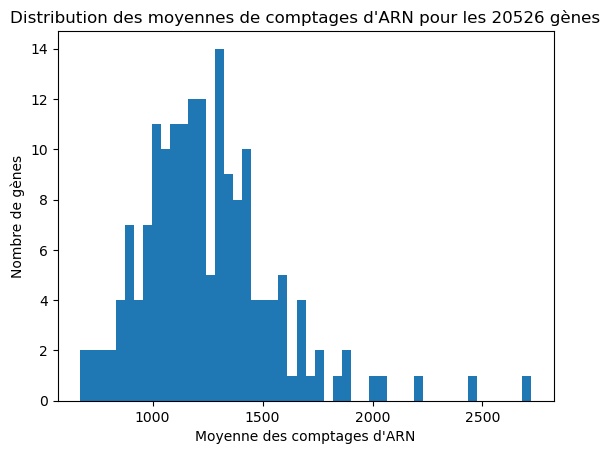

In [60]:
# Calculer la moyenne pour chaque gène à travers tous les échantillons
gene_means = merged_df.mean(axis=1, numeric_only=True)

# Tracer l'histogramme des moyennes de comptages d'ARN
plt.hist(gene_means, bins=50)
plt.xlabel("Moyenne des comptages d'ARN")
plt.ylabel("Nombre de gènes")
plt.title("Distribution des moyennes de comptages d'ARN pour les " + str(resultats.shape[0]) + " gènes")
plt.show()

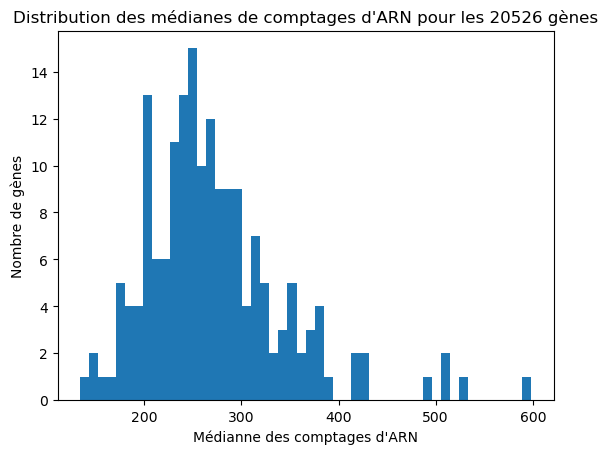

In [61]:
# Calculer la médiane pour chaque gène à travers tous les échantillons
gene_medians = merged_df.median(axis=1, numeric_only=True)

# Tracer l'histogramme des moyennes de comptages d'ARN
plt.hist(gene_medians, bins=50)
plt.xlabel("Médianne des comptages d'ARN")
plt.ylabel("Nombre de gènes")
plt.title("Distribution des médianes de comptages d'ARN pour les " + str(resultats.shape[0]) + " gènes")
plt.show()

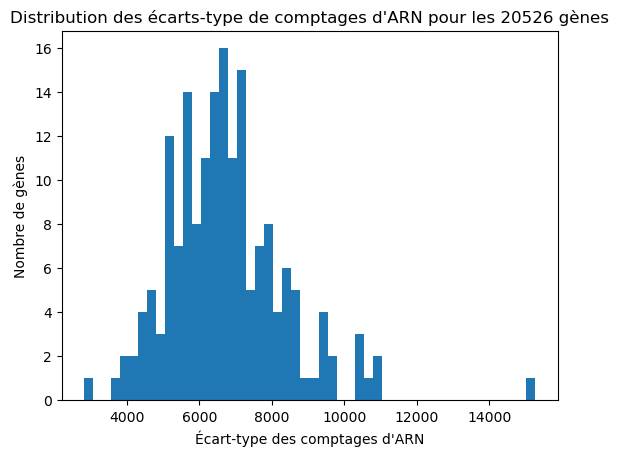

In [62]:
# Calculer l'écart-type pour chaque gène à travers tous les échantillons
gene_std = merged_df.std(axis=1, numeric_only=True)

# Tracer l'histogramme des moyennes de comptages d'ARN
plt.hist(gene_std, bins=50)
plt.xlabel("Écart-type des comptages d'ARN")
plt.ylabel("Nombre de gènes")
plt.title("Distribution des écarts-type de comptages d'ARN pour les " + str(resultats.shape[0]) + " gènes")
plt.show()

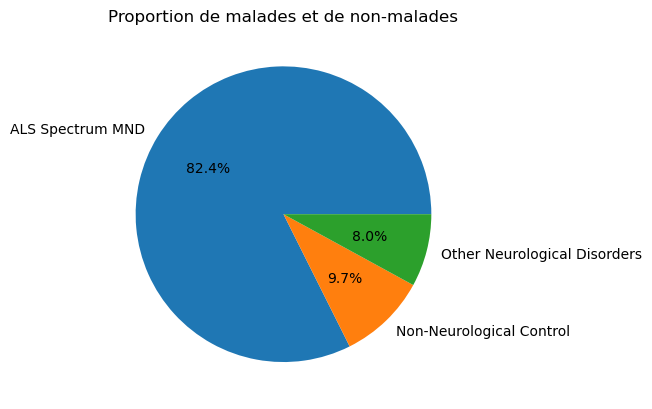

In [63]:
# compter le nombre de malades et de non-malades
status_counts = merged_df['Sample group'].value_counts()

# dessiner un camembert
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
plt.title('Proportion de malades et de non-malades')
plt.show()

#### Calcul pour les sous-ensembles de patients (malades(ALS) et non-malade(ALS))

In [64]:
# Sous-ensemble de données pour les patients atteints d'ALS
als_df = merged_df[merged_df['Sample group'] == 'ALS Spectrum MND']

# Sous-ensemble de données pour les patients sains
healthy_df = merged_df[(merged_df['Sample group'] == 'Non-Neurological Control')]

###### Les patients atteint d'ALS

In [65]:
moyennesALS = als_df.mean(axis=0, numeric_only=True)
medianesALS = als_df.median(axis=0, numeric_only=True)
ecart_typesALS = als_df.std(axis=0, numeric_only=True)
# Créer un nouveau dataframe pour stocker les résultats
resultatsALS = pd.DataFrame({'moyenne': moyennesALS, 'mediane': medianesALS, 'ecart_type': ecart_typesALS})

# Afficher les résultats
display(resultatsALS)

,moyenne,mediane,ecart_type
A1BG,37.710345,33.0,20.312803
A1BG-AS1,119.379310,109.0,51.383778
A2M,2486.924138,2222.0,1338.114568
A2M-AS1,103.503448,95.0,35.813972
A2ML1,124.496552,116.0,57.691122
...,...,...,...
X8_LINE:CR1:LINE,460.924138,446.0,131.111174
X9_LINE:L1:LINE,111.420690,107.0,33.177483
Zaphod2:hAT-Tip100:DNA,417.931034,415.0,127.511909
Zaphod3:hAT-Tip100:DNA,1553.972414,1540.0,476.597270


##### Les patients non atteint d'ALS

In [66]:
moyennesSaint = healthy_df.mean(axis=0, numeric_only=True)
medianesSaint = healthy_df.median(axis=0, numeric_only=True)
ecart_typesSaint = healthy_df.std(axis=0, numeric_only=True)
# Créer un nouveau dataframe pour stocker les résultats
resultatsSaint = pd.DataFrame({'moyenne': moyennesSaint, 'mediane': medianesSaint, 'ecart_type': ecart_typesSaint})

# Afficher les résultats
display(resultatsSaint)

,moyenne,mediane,ecart_type
A1BG,39.764706,34.0,24.605714
A1BG-AS1,122.705882,124.0,31.003558
A2M,2609.941176,2560.0,975.340227
A2M-AS1,92.470588,88.0,32.950944
A2ML1,134.058824,132.0,37.325378
...,...,...,...
X8_LINE:CR1:LINE,482.411765,493.0,128.792983
X9_LINE:L1:LINE,108.235294,106.0,36.567625
Zaphod2:hAT-Tip100:DNA,432.647059,431.0,100.770743
Zaphod3:hAT-Tip100:DNA,1665.823529,1679.0,407.932016


## Step 3 - PCA

Nous allons tout d'abord encoder notre DataFrame avec le One-Hot

In [67]:
#merged_df = merged_df.drop(merged_df[merged_df['Sample group'] == 'Other Neurological Disorders'].index)
merged_df['Sample group'] = merged_df['Sample group'].replace({'ALS Spectrum MND': 1, 'Non-Neurological Control': 0, 'Other Neurological Disorders' :1})
# Sélectionner toutes les caractéristiques sauf 'class'
features = merged_df.drop('Sample group', axis=1).columns.tolist()
features = merged_df.drop('Subject id', axis=1).columns.tolist()
# Encoder les caractéristiques non numériques avec get_dummies()
Dataset_encoded = pd.get_dummies(merged_df[features])

# Ajouter la colonne 'class' au dataframe encodé
Dataset_encoded['Sample group'] = merged_df['Sample group']

# Afficher le dataframe encodé
display(Dataset_encoded)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AA06,AAAS,AACS,AACSP1,...,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,Sample group,Cns_subregion_Frontal Cortex,Cns_subregion_Motor Cortex,Cns_subregion_Motor Cortex (Lateral),Cns_subregion_Motor Cortex (Medial)
GSM3533405,76,193,4278,140,102,141,40,261,1089,24,...,456,104,427,1619,1751,1,1,0,0,0
GSM3533404,124,332,3516,141,173,192,15,462,2419,14,...,479,120,503,1646,1839,1,1,0,0,0
GSM3533403,64,290,4752,118,174,135,22,336,2088,17,...,358,107,347,1284,1469,1,1,0,0,0
GSM3533402,134,300,6077,171,42,225,35,633,1932,11,...,460,109,399,1619,1724,1,1,0,0,0
GSM3533401,23,113,2130,72,71,21,19,222,878,12,...,320,73,311,1102,1169,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533234,22,102,1706,83,178,31,30,144,1070,9,...,582,124,539,1742,1939,1,1,0,0,0
GSM3533233,22,101,2131,142,143,36,40,209,912,26,...,562,132,540,2032,2135,1,1,0,0,0
GSM3533232,20,95,1830,121,127,11,39,202,686,20,...,571,126,479,1659,1778,1,1,0,0,0
GSM3533231,25,107,1787,153,109,25,34,229,876,17,...,582,153,552,2057,2279,1,1,0,0,0


In [68]:
from sklearn.model_selection import train_test_split
# Chargement des données
X = Dataset_encoded.drop('Sample group', axis=1) # les données d'expression génique
y = merged_df['Sample group'] # les étiquettes de groupe (0 ou 1)
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Standardisation

In [69]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
N_COMP = 4   #Mettre 20 dans le rapport pour justifier le choix de 4

pca = decomposition.PCA(n_components=N_COMP)
# Appliquer la PCA sur les données d'entraînement standardisées
X_train_pca = pca.fit_transform(X_train)

# Appliquer la même transformation de PCA sur les données de test standardisées
X_test_pca = pca.transform(X_test)

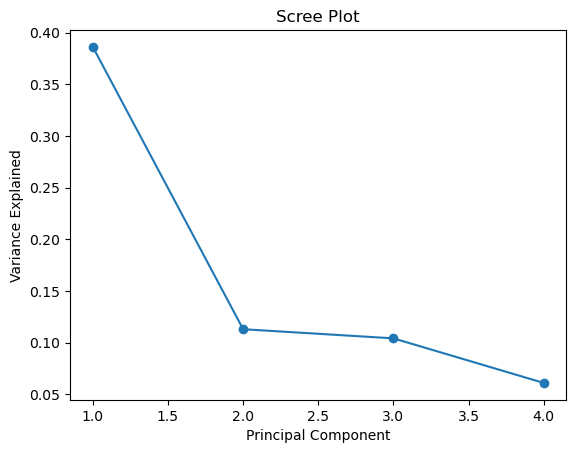

In [71]:
pc2 = np.arange(pca.n_components_) + 1


plt.plot(pc2, pca.explained_variance_ratio_, 'o-')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

In [72]:
sum(pca.explained_variance_ratio_)

0.6645153272504214

## Step 5 - Univariate analysis

### T-test implementation


In [73]:
first_gene = merged_df.iloc[:,0] # with data_matrix a dataframe containing the RNA count, with samples in row and genes in column
print(first_gene)

GSM3533405     76
GSM3533404    124
GSM3533403     64
GSM3533402    134
GSM3533401     23
             ... 
GSM3533234     22
GSM3533233     22
GSM3533232     20
GSM3533231     25
GSM3533230     42
Name: A1BG, Length: 176, dtype: int64


In [74]:
annotations_df = mesAnnotations.get_DataFrame().iloc[::-1]
als_index = annotations_df['Sample group'] == 'ALS Spectrum MND'  # with data_annotation the dataframe containing the annotation
ctrl_index = annotations_df['Sample group'] == 'Non-Neurological Control'
first_gene_als = first_gene[als_index.values]
first_gene_ctrl = first_gene[ctrl_index.values]

In [75]:
pvalue_first_gene = ttest_ind(first_gene_als, first_gene_ctrl).pvalue
print(pvalue_first_gene)

0.7270889277154782


In [76]:
test = DataMatrix.get_DataFrame()
pvalues = test.apply(lambda x: ttest_ind(x[als_index.values], x[ctrl_index.values]).pvalue)
#t_statistic, p_values = ttest_ind(moyennesSaint, moyennesALS, equal_var=False)

In [77]:
print(DataMatrix.get_DataFrame().shape)

(176, 20526)


In [78]:
print(pvalues.shape)

(20526,)


In [79]:
print("Est ce qu'il ya des NaN : " + str(pvalues.isnull().values.any()))


Est ce qu'il ya des NaN : False


### Multiple testing

In [80]:
(areSignificant, correctedPValues, _, _) = statsmodels.multipletests(pvalues, method='fdr_bh')

In [81]:
colnames = list( DataMatrix.get_DataFrame().columns)
print(len(colnames))

bidule = DataMatrix.get_DataFrame()
cpt = 0;

for i in range (len(areSignificant)-1):
    if(areSignificant[i] == False):
        truc = colnames[i]
        cpt += 1;
        bidule = bidule.drop(truc, axis=1)
print(cpt)
print(bidule.shape)



20526
20218
(176, 308)


# Nouvelles Datas Sélectionnées

In [82]:
bidule

gene/TE,ABCC8,ABO,ACTG1P4,ADAM8,ADAMTS10,ADAMTS7P1,AFG3L1P,AGER,AIFM2,AK8,...,XAF1,ZAP70,ZDHHC19,ZFR2,ZMIZ1-AS1,ZNF251,ZNF534,BSR/Beta:Satellite:Satellite,HERVI-int:ERV1:LTR,Zaphod:hAT-Tip100:DNA
GSM3533405,1039,30,138,78,779,124,338,31,264,43,...,256,9,11,362,50,391,157,807,369,1751
GSM3533404,1318,43,186,81,690,127,371,40,274,108,...,463,18,7,787,61,568,180,1245,347,1839
GSM3533403,1309,19,109,51,611,84,286,20,232,60,...,287,14,14,587,47,501,141,1031,247,1469
GSM3533402,1001,45,152,107,663,93,471,65,353,53,...,529,26,3,616,47,521,136,1307,452,1724
GSM3533401,710,10,66,25,305,52,184,16,110,29,...,267,2,1,295,37,267,98,705,194,1169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533234,674,8,72,33,188,22,138,13,102,14,...,178,1,5,145,13,274,55,512,338,1939
GSM3533233,842,18,111,56,332,54,172,11,113,17,...,174,9,6,216,38,274,87,955,338,2135
GSM3533232,386,7,69,14,177,28,152,8,99,14,...,152,5,2,179,13,251,98,760,268,1778
GSM3533231,505,7,107,29,208,39,170,11,88,19,...,215,5,5,170,43,259,69,744,313,2279


In [83]:
print(y)

GSM3533405    1
GSM3533404    1
GSM3533403    1
GSM3533402    1
GSM3533401    1
             ..
GSM3533234    1
GSM3533233    1
GSM3533232    1
GSM3533231    1
GSM3533230    1
Name: Sample group, Length: 176, dtype: int64


In [84]:
X_final = bidule
y_final = y

# Division en ensembles d'entraînement et de test
X_trainF, X_testF, y_trainF, y_testF = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

X_trainF = scaler.fit_transform(X_trainF)
X_testF = scaler.transform(X_testF)

++++++++++++++++++++++++++++++++++++++


In [85]:
areSignificantIndex = []
index = 0
for i in areSignificant:
    if(areSignificant[index]) :
        areSignificantIndex.append(index)
    index += 1
significantPValues = []
for i in areSignificantIndex:
    significantPValues.append(correctedPValues[i])

### Graphical representation

In [86]:
log2fc = np.log2(moyennesALS/moyennesSaint)
print(log2fc)

A1BG                     -0.076528
A1BG-AS1                 -0.039652
A2M                      -0.069655
A2M-AS1                   0.162612
A2ML1                    -0.106760
                            ...   
X8_LINE:CR1:LINE         -0.065736
X9_LINE:L1:LINE           0.041846
Zaphod2:hAT-Tip100:DNA   -0.049926
Zaphod3:hAT-Tip100:DNA   -0.100275
Zaphod:hAT-Tip100:DNA    -0.079175
Length: 20526, dtype: float64


In [87]:
fc_tab = []
for i in areSignificantIndex:
    fc_tab.append(log2fc[i])

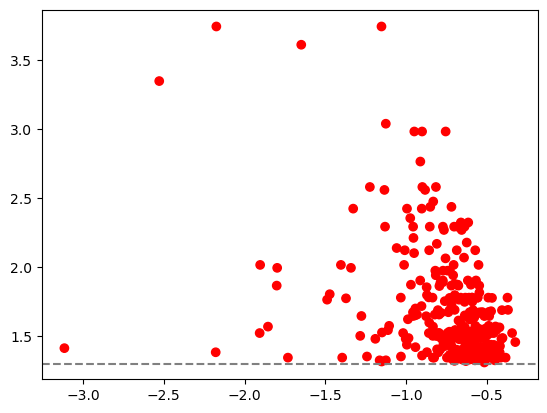

In [88]:
threshold = 0.05

canBeCompared = np.array(significantPValues)

color = np.where(canBeCompared <= threshold, 'red', 'grey')
fig, ax = plt.subplots()
ax.scatter(fc_tab, -np.log10(significantPValues), c=color)
ax.axhline(-np.log10(threshold), color = 'gray', linestyle='--')

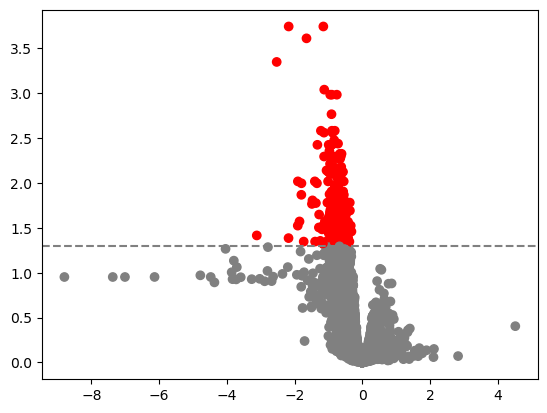

In [89]:
canBeCompared = np.array(correctedPValues)

color = np.where(canBeCompared <= threshold, 'red', 'grey')
fig, ax = plt.subplots()
ax.scatter(log2fc, -np.log10(correctedPValues), c=color)
ax.axhline(-np.log10(threshold), color = 'gray', linestyle='--')

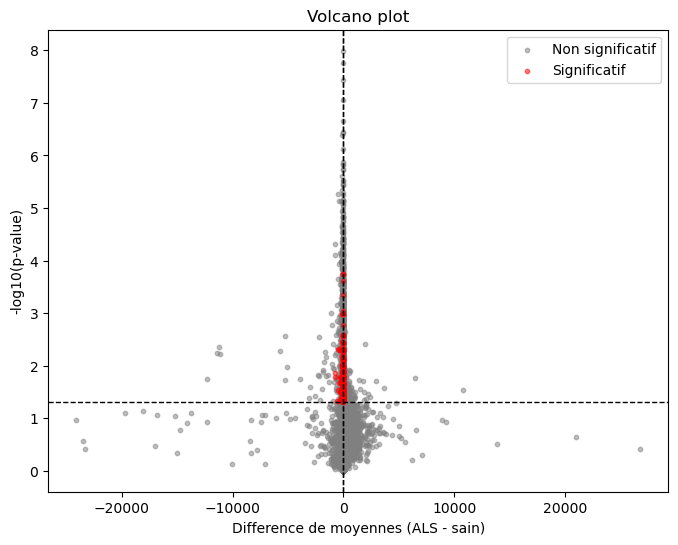

In [90]:
from scipy import stats
import statsmodels.api as sm
# Calcul des différences de moyennes et des p-values non corrigées
diff_means = moyennesALS - moyennesSaint
# Tracé du volcano plot
plt.figure(figsize=(8,6))
plt.scatter(diff_means, -np.log10(pvalues), color='grey', alpha=0.5, s=10)
plt.scatter(diff_means[areSignificant], -np.log10(correctedPValues[areSignificant]), color='red', alpha=0.5, s=10)

# Ajout des seuils de régulation et de significativité
plt.axvline(x=2, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-2, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)

# Ajout des légendes
plt.xlabel('Difference de moyennes (ALS - sain)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano plot')
plt.legend(('Non significatif', 'Significatif'), loc='upper right')

plt.show()

## STEP 6 - Multivariate Analysis - Elastic-Net

In [91]:
from sklearn.linear_model import LogisticRegressionCV

# Régression logistique avec Elastic-Net
clf = LogisticRegressionCV(penalty='elasticnet', cv= 5, solver='saga', l1_ratios=[0.25,0.5,0.75], Cs=[0.1,0.5], scoring= 'accuracy', max_iter=300, random_state = 42)
clf.fit(X_trainF, y_trainF)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

LogisticRegressionCV(Cs=[0.1, 0.5], cv=5, l1_ratios=[0.25, 0.5, 0.75],
                     max_iter=300, penalty='elasticnet', random_state=42,
                     scoring='accuracy', solver='saga')

In [92]:
import sklearn
model_prediction = clf.predict(X_testF)
accuracy_train_dataset = sklearn.metrics.accuracy_score(y_testF, model_prediction)
print(accuracy_train_dataset)
print (" ")
print(metrics.classification_report(y_testF, model_prediction))

0.9056603773584906
 
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.92      0.98      0.95        46

    accuracy                           0.91        53
   macro avg       0.83      0.70      0.75        53
weighted avg       0.90      0.91      0.89        53



In [93]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_testF, model_prediction)

0.703416149068323

In [94]:
from sklearn.metrics import roc_auc_score
sklearn.metrics.roc_auc_score(y_testF, model_prediction)

0.703416149068323

In [95]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_testF, model_prediction)

0.5214531846240801

In [96]:
unique, frequency = np.unique(y_trainF, return_counts = True)
print("Unique Values:", unique) 
print("Frequency Values:", frequency)

Unique Values: [0 1]
Frequency Values: [ 10 113]


In [97]:
clf.coef_

array([[ 0.00000000e+00, -9.37188171e-03,  3.45746312e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.65880767e-01,
        -4.05445299e-01,  0.00000000e+00,  9.76876420e-03,
         0.00000000e+00,  0.00000000e+00, -4.43337251e-02,
        -3.49537055e-02,  0.00000000e+00,  9.65438444e-03,
         0.00000000e+00, -1.13192349e-01,  0.00000000e+00,
        -1.21009279e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.37857386e-02,  0.00000000e+00,  0.00000000e+00,
        -1.72929841e-03,  0.00000000e+00, -1.02872067e-02,
         0.00000000e+00, -7.78182559e-02,  0.00000000e+00,
        -1.22915563e-03, -6.92674865e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

### Données test

In [98]:
DataMatrix = Data_Matrix("Data_test/")
DataMatrix.afficher()

gene/TE,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3477254,67,194,0,5665,76,207,2,1,46,0,...,437,1140,1144,549,32,327,37,263,1407,1429
GSM3477253,63,179,0,6862,81,327,2,0,64,0,...,591,1437,1419,612,38,410,47,383,1598,1808
GSM3477252,70,217,0,2362,53,148,3,4,52,0,...,446,1345,1297,614,45,351,57,390,1614,1679
GSM3477251,72,141,0,1735,94,126,3,6,38,1,...,476,1209,1209,565,36,296,43,324,1465,1602
GSM3477250,41,132,2,5229,79,147,5,6,46,1,...,399,1112,1136,530,43,302,48,343,1433,1696
GSM3477249,64,168,1,8412,112,247,0,6,45,2,...,442,1297,1356,764,48,366,70,423,1690,1879
GSM3477248,19,105,0,3781,57,97,0,0,21,1,...,363,901,848,468,32,241,41,265,1146,1168
GSM3477247,16,69,0,2443,53,79,0,0,23,0,...,312,808,671,447,36,221,47,237,969,1058
GSM3477246,28,76,0,3462,98,141,4,2,15,1,...,508,1118,992,520,42,276,50,294,1290,1593
GSM3477245,18,86,0,3317,70,145,0,6,18,0,...,355,880,881,473,64,238,42,236,978,1384


In [99]:
df_means = DataMatrix.get_DataFrame().mean(axis=0)

In [100]:
# On a fixé le seuil de pertinance des moyennes à 5
df_filtered = DataMatrix.get_DataFrame().loc[:, df_means > 4] 
DataMatrix.set_DataFrame(df_filtered)

In [101]:
class sample_Annotation2:
    
    # --- Constructeur ---
    def __init__(self, XML_File):
        self.DataFrame = pd.DataFrame() 
        temp = []
        xtree = et.parse("Data_test/GSE122649_family.xml") 

        xroot = xtree.getroot() 
        for child in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
            temp_sample_id = child.attrib['iid'] 
            temp_cns_subregion = ""
            temp_cns_tissu = ""
            temp_cns_subject = ""
            temp_cns_sample = ""
            temp_cns_source = ""
            for child2 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
                if(child2.attrib["tag"] == "tissue"):
                    temp_cns_subregion = str.strip(child2.text.replace('\n', ''))
                #if(child2.attrib["tag"] == "tissue type"):
                    #temp_cns_tissu = str.strip(child2.text.replace('\n', ''))
                if(child2.attrib["tag"] == "subject id"):
                    temp_cns_subject = str.strip(child2.text.replace('\n', ''))
                if(child2.attrib["tag"] == "diagnosis"):
                    temp_cns_sample = str.strip(child2.text.replace('\n', ''))
            #for child3 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Source"):    
                #temp_cns_source = str.strip(child3.text)
            
            temp_df = pd.DataFrame({'gene/TE': [temp_sample_id], 'Cns_subregion': [temp_cns_subregion], "Subject id": [temp_cns_subject],  "Sample group": [temp_cns_sample]})
            temp_df = temp_df.set_index('gene/TE')
            self.DataFrame = pd.concat([self.DataFrame, temp_df])
            self.DataFrame.reindex(index=self.DataFrame.index[::-1])
            
    # --- Getters ---
    def get_DataFrame(self):
        return self.DataFrame
    
    # --- Méthodes ---
    def afficher(self):
        with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
            display(self.DataFrame)

In [102]:
mesAnnotations2 = sample_Annotation2("Data_test/GSE122649_family.xml")
display(mesAnnotations2.get_DataFrame())

,Cns_subregion,Subject id,Sample group
gene/TE,,,
GSM3477217,motor cortex,JR9,sALS
GSM3477218,motor cortex,JR9,sALS
GSM3477219,motor cortex,JR48,sALS
GSM3477220,motor cortex,JR48,sALS
GSM3477221,motor cortex,JR29,sALS
GSM3477222,motor cortex,JR29,sALS
GSM3477223,motor cortex,JR30,sALS/FTD
GSM3477224,motor cortex,JR30,sALS/FTD
GSM3477225,motor cortex,JR33,sALS


In [103]:
merged_df = pd.merge(DataMatrix.get_DataFrame(), mesAnnotations2.get_DataFrame(), left_index=True, right_index=True)
display (merged_df)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AA06,AAAS,AACS,AACSP1,...,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,Cns_subregion,Subject id,Sample group
GSM3477254,67,194,5665,76,207,46,42,478,1322,7,...,549,32,327,37,263,1407,1429,motor cortex,JR73,Non-neurological control
GSM3477253,63,179,6862,81,327,64,58,484,1362,6,...,612,38,410,47,383,1598,1808,motor cortex,JR73,Non-neurological control
GSM3477252,70,217,2362,53,148,52,62,370,1706,24,...,614,45,351,57,390,1614,1679,motor cortex,JR70,Non-neurological control
GSM3477251,72,141,1735,94,126,38,40,348,1316,14,...,565,36,296,43,324,1465,1602,motor cortex,JR70,Non-neurological control
GSM3477250,41,132,5229,79,147,46,37,311,937,19,...,530,43,302,48,343,1433,1696,motor cortex,JR65,Non-neurological control
GSM3477249,64,168,8412,112,247,45,29,359,1256,23,...,764,48,366,70,423,1690,1879,motor cortex,JR65,Non-neurological control
GSM3477248,19,105,3781,57,97,21,60,220,785,18,...,468,32,241,41,265,1146,1168,motor cortex,JR67,Non-neurological control
GSM3477247,16,69,2443,53,79,23,44,191,661,13,...,447,36,221,47,237,969,1058,motor cortex,JR67,Non-neurological control
GSM3477246,28,76,3462,98,141,15,52,244,674,22,...,520,42,276,50,294,1290,1593,motor cortex,JR44,Non-neurological control
GSM3477245,18,86,3317,70,145,18,32,264,493,14,...,473,64,238,42,236,978,1384,motor cortex,JR44,Non-neurological control


In [104]:
#merged_df = merged_df.drop(merged_df[merged_df['Sample group'] == 'Other Neurological Disorders'].index)
merged_df['Sample group'] = merged_df['Sample group'].replace({'sALS': 1, 'Non-neurological control': 0, 'sALS/FTD' :1})
# Sélectionner toutes les caractéristiques sauf 'class'
features = merged_df.drop('Sample group', axis=1).columns.tolist()
features = merged_df.drop('Subject id', axis=1).columns.tolist()
# Encoder les caractéristiques non numériques avec get_dummies()
Dataset_encoded = pd.get_dummies(merged_df[features])

# Ajouter la colonne 'class' au dataframe encodé
Dataset_encoded['Sample group'] = merged_df['Sample group']

# Afficher le dataframe encodé
display(Dataset_encoded)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,AA06,AAAS,AACS,AACSP1,...,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA,Sample group,Cns_subregion_motor cortex
GSM3477254,67,194,5665,76,207,46,42,478,1322,7,...,1144,549,32,327,37,263,1407,1429,0,1
GSM3477253,63,179,6862,81,327,64,58,484,1362,6,...,1419,612,38,410,47,383,1598,1808,0,1
GSM3477252,70,217,2362,53,148,52,62,370,1706,24,...,1297,614,45,351,57,390,1614,1679,0,1
GSM3477251,72,141,1735,94,126,38,40,348,1316,14,...,1209,565,36,296,43,324,1465,1602,0,1
GSM3477250,41,132,5229,79,147,46,37,311,937,19,...,1136,530,43,302,48,343,1433,1696,0,1
GSM3477249,64,168,8412,112,247,45,29,359,1256,23,...,1356,764,48,366,70,423,1690,1879,0,1
GSM3477248,19,105,3781,57,97,21,60,220,785,18,...,848,468,32,241,41,265,1146,1168,0,1
GSM3477247,16,69,2443,53,79,23,44,191,661,13,...,671,447,36,221,47,237,969,1058,0,1
GSM3477246,28,76,3462,98,141,15,52,244,674,22,...,992,520,42,276,50,294,1290,1593,0,1
GSM3477245,18,86,3317,70,145,18,32,264,493,14,...,881,473,64,238,42,236,978,1384,0,1


In [108]:
colnames2 = list( Dataset_encoded.columns)
print(len(colnames2))

X = Dataset_encoded.drop('Sample group', axis=1)
cpt = 0;

for i in range (len(areSignificant)-1):
    if(areSignificant[i] == False):
        truc = colnames2[i]
        cpt += 1;
        X = X.drop(truc, axis=1)
print(cpt)
print(bidule.shape)

#X = Dataset_encoded.drop('Sample group', axis=1) # les données d'expression génique
y = Dataset_encoded['Sample group'] # les étiquettes de groupe (0 ou 1)
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

20812
20218
(176, 308)


In [109]:
clf.predict(Dataset_encoded)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


ValueError: X has 20812 features, but LogisticRegressionCV is expecting 308 features as input.